# Reachability Analysis for Split Computing Neural Networks

## 1. Import Packages

In [23]:
begin
	import Pkg
	Pkg.activate("..")
	Pkg.instantiate()
	
    push!(LOAD_PATH, "$(@__DIR__)/../src")
    
    using Plots
    using NoisyReach
    using Distributions
    using Experiment
    using QuadGK
    using ControlSystemsBase
    using LinearAlgebra
    using ReachabilityAnalysis
end

  Activating project at `~/sc/NoisyReach.jl`


## 2. Validation for Integral function

In [24]:
#const Ts = 0.01
#const Dc = 0.005
#sys = benchmarks[:F1]

In [25]:
#sys_aug_ = let
#    ϕ = ℯ^(Ts * sys.A)
#    Γ₁ = matrix_integral(sys.A, sys.B, Dc, Ts)
#    Γ₀ = matrix_integral(sys.A, sys.B, 0.0, Ts - Dc)
#    ϕ_aug = [ϕ Γ₁; 0 0 0]
#    Γ_aug = [Γ₀; I]
#    C_aug = [sys.C 0]
#    ss(ϕ_aug, Γ_aug, C_aug, sys.D, Ts)
#end

In [26]:
#sys_aug = c2d(sys, Ts) * delay(Dc, Ts)
#sys_aug = c2d(sys, Ts) * thiran(Dc, Ts)

## 3. Physical System and Neural Networks Uncertainty Setup

In [27]:
sys = benchmarks[:F1]
const period = 0.02
const Dc1 =    0.005
const Dc2 =    0.015

0.015

In [28]:
sys_ideal = c2d(sys, period)
K_ideal = lqr(ControlSystemsBase.Discrete, sys_ideal.A, sys_ideal.B, I, I)

1×2 Matrix{Float64}:
 0.777044  1.05686

In [29]:
sys_aug = let
    ϕ = ℯ^(period * sys.A)
    Γ2 = matrix_integral(sys.A, sys.B, Dc2, period)
    Γ1 = matrix_integral(sys.A, sys.B, Dc1, Dc2)
    Γ3 = matrix_integral(sys.A, sys.B, 0.0, Dc1)
    ϕ_aug = [ϕ Γ3; 0 0 0]
    Γ_aug = [Γ1 Γ2; 0 I]
    C_aug = [sys.C 0]
    D_aug = [sys.D 0]
    ss(ϕ_aug, Γ_aug, C_aug, D_aug, period)
end
K = lqr(ControlSystemsBase.Discrete, sys_aug.A, sys_aug.B, I, I)

2×3 Matrix{Float64}:
 0.723651  1.09385  0.0995609
 0.307036  0.48328  0.0441294

In [30]:
σ1 = 0.3
σ2 = 0.2
μ = 0.
H = 10
x0 = 1.
u1_0 = 0.
u2_0 = 0.
u0 = 0.
z0 = [fill(x0, size(sys.A, 1)); u2_0]
x0 = fill(x0, size(sys.A, 1))

2-element Vector{Float64}:
 1.0
 1.0

## 4. Calculate and Plot Reachable Trajectories

In [31]:
all_trajectories=[]
number = 10000
for i in 1:number
    z = evolve(sys_aug.A, sys_aug.B, K, H, z0, u1_0, u2_0, σ1, σ2, μ)
    push!(all_trajectories, z)
end
z_ideal = ideal_evolve(sys_ideal.A, sys_ideal.B, K_ideal, H, x0, u0)

11-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.13, 1.0]
 [1.309515718837338, 1.7617802898052037]
 [1.6122354116671223, 2.8954457537299385]
 [2.0990119492507007, 4.5934240552481915]
 [2.8621281948210733, 7.146825876603693]
 [4.041419731203601, 10.996120836973658]
 [5.848676622359113, 16.807831334649606]
 [8.604574840500852, 25.590602790607925]
 [12.79457040489092, 38.87086743077775]
 [19.15349221360622, 58.95869885714997]

In [32]:
const xlim = 60
const ylim = 250
Plots.scalefontsizes(1.5)

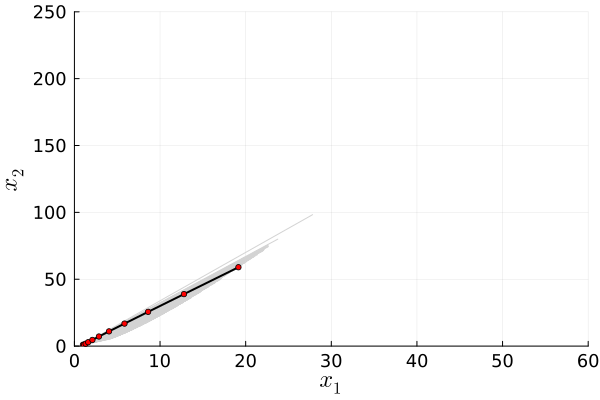

"/home/pgan/sc/NoisyReach.jl/experiments/moreNN1.svg"

In [35]:
traj_plot = plot(xlabel="\$x_1\$", ylabel="\$x_2\$")#, title="Trajectories")
for trajectory in all_trajectories
    x = [point[1] for point in trajectory]
    y = [point[2] for point in trajectory]
    
    plot!(x, y, xlim=(0, xlim), ylim=(0, ylim), label="", linecolor=:lightgray, linewidth=1)#, marker=:circle, markercolor=:yellow, markersize=2)
end
x_z = [point[1] for point in z_ideal]
y_z = [point[2] for point in z_ideal]
plot!(x_z, y_z, xlim=(0, xlim), ylim=(0, ylim), label="", linecolor=:black, linewidth=2, marker=:circle, markercolor=:red, markersize=3)
display(traj_plot)
savefig(traj_plot, "moreNN1.svg")